# Assignment14: LSTM

LSTM model on Amazon Fine Food Reviews

### Objective:
 * Apply LSTM model with different architectures & number of layers on Amazon food reviews.
 * Plots Traing and testing error plot.

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
%matplotlib inline
import re
from datetime import datetime
import math
import pandas as pd
import numpy as np
import nltk
import string
import pickle 
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
                                                               

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty):
  fig = plt.figure( facecolor='c', edgecolor='k')
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Categorical Crossentropy Loss')
  plt.legend()
  plt.grid()
  plt.show()

### To upload the reviews.zip file from system to google colab

In [0]:
# Reference link 
# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.7MB/s 


In [0]:
link = 'https://drive.google.com/file/d/1p5YpkUos0Rd6Hsae1qaH0VsPtnLdlnc0/view?usp=sharing'

In [0]:
fluff, id = link.split('=')
id='1p5YpkUos0Rd6Hsae1qaH0VsPtnLdlnc0'
print (id)

1p5YpkUos0Rd6Hsae1qaH0VsPtnLdlnc0


In [0]:
 downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Reviews.csv')  


In [0]:
amz = pd.read_csv('Reviews.csv')
# dimensions of dataset and columns name
print(amz.shape) 
#print(amz1.shape)
print(amz.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


Given reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating. If score is equal to 3,it is considered as neutral score.

In [0]:
# Processing
#Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def score_part(x):
    if x < 3:
        return 0
    return 1

actualScore = amz['Score']
#print(actualScore)
New_score = actualScore.map(score_part)
#print(New_score)
amz['Score']=New_score

In [0]:
print(amz.shape)
amz.head(2)


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


#### Data Pre-processing on raw data:

Every datasets contains some unwanted data.Raw data is preprocessed by removing duplication.


In [0]:
#Processing of ProductId
#Sorting data according to ProductId in ascending order
sorted_data=amz.sort_values('ProductId', axis=0, ascending=True, 
                            inplace=False, kind='quicksort', 
                            na_position='last')
#sorted_data.head() # printing sorted data
# To check the duplications in raw data
dupli=sorted_data[sorted_data.duplicated(["UserId","ProfileName","Time","Text"])]
print(dupli.head(2))
# Remove Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(amz['Id'].size*1.0)*100
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)



            Id   ProductId         UserId  \
171222  171223  7310172001  AJD41FBJD9010   
171153  171154  7310172001  AJD41FBJD9010   

                                         ProfileName  HelpfulnessNumerator  \
171222  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     1   
171153  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   

        HelpfulnessDenominator  Score        Time  \
171222                       1      1  1233360000   
171153                       0      1  1233360000   

                                                  Summary  \
171222  best dog treat-- great for training---  all do...   
171153  best dog treat-- great for training---  all do...   

                                                     Text  
171222  Freeze dried liver has a hypnotic effect on do...  
171153  Freeze dried liver has a hypnotic effect on do...  
(393931, 10)


In [0]:
final = final[final['ProductId'] != '7310172001']


# Text Preprocessing:

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
 
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>$< /><')
    #cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase.

'''Pre processing of text data:It is cleaning and flitering text'''
i=0
str1=' '
global final_string
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1


##### Dumping and loading  Pre processing of text data in pickle file 

In [0]:
pickle_path_final_string='final_string.pkl'
final_string_file=open(pickle_path_final_string,'wb')
pickle.dump(final_string,final_string_file)
final_string_file.close()

In [0]:
pickle_path_final_string='final_string.pkl'
final_string_unpkl=open(pickle_path_final_string,'rb')
final_string=pickle.load(final_string_unpkl)

In [0]:

final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()


Shape of final (393761, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,saw charm rose pep chicken chicken great book ...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movi sound track sing along carol king gre...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertain rhyme catchi illustr imagin fit righ...


# Converting Reviews Data into IMDB Dataset

In [0]:
##Sorting data according to Time in ascending order
## Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, 
                                     ascending=True, 
                                     inplace=False,
                                     kind='quicksort', 
                                     na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

#  vocabulary of words using countvectorizer
count_vect = CountVectorizer() 
count_vect.fit(x)

vocabulary = count_vect.get_feature_names()
print('No. of words in the Vocabulary : ',len(vocabulary))

No. of words in the Vocabulary :  73405


In [0]:
# Storing words in vocabary 
word_dict=dict()
index=0
for words in x:
  for word in words.split():
    word_dict.setdefault(word,[])
    word_dict[word].append(index)
    index+=1

    
# Getting frequency for each word of vocabulary 

freq = []
for w in vocabulary:
  freq.append(len(word_dict[w]))
    
    
print("done")

done


In [0]:
# sort the frequency in decending order 

new_index=np.argsort(np.array(freq))[::-1]

In [0]:
# Allocate rank to freq in decending order
word_rank=dict()
rank=1
for i in new_index:
  word_rank[vocabulary[i]]=rank
  rank+=1

##### converting data into imdb format

In [0]:
review_data=[]
for sent in x:
  row=[]
  for word in sent.split():
    if len(word)>1 :
      row.append(word_rank[word])
  review_data.append(row)

In [0]:
# Splitting the data into 60-40 train_data and test_data
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(review_data, y, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [0]:
print("length of X_train :",len(X_train))
print("length of  X_test :",len(X_test))
print("Shape of Y_train :",Y_train.shape)
print("Shape of Y_test :",Y_test.shape)

length of X_train : 196880
length of  X_test : 196881
Shape of Y_train : (196880,)
Shape of Y_test : (196881,)


In [0]:
print( review_data[0])

[13351, 27, 1106, 14, 379, 2444, 3182, 13972, 1142, 1241, 545, 109, 3845, 7102, 860, 800, 10363, 1852, 11939, 8, 174, 780, 1106, 1082, 2807, 1211, 1106, 1429, 1860, 379, 79, 263, 13972, 1438, 1699]


In [0]:

# truncate and/or pad input sequences
max_review_length = 120
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])
print(X_test.shape)

(196880, 120)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    37
   293  1255  2912   478    29    41    26   639  2978   412  3887   919
  1305  1753    87   287   378   328   582   172   419   326   117    41
  2610   410  1399   826   631   113  1386  1014 10807   478    62    50]
(196881, 120)


In [0]:
len_voc=len(vocabulary)+1
print(len_voc)

73406


# 1 RNN with 1 LSTM layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 32)           2348992   
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,402,293
Trainable params: 2,402,293
Non-trainable params: 0
_________________________________________________________________
None
Train on 196880 samples, validate on 196881 samples
Epoch 1/10
196880/196880 [==============================] - 518s 3ms/step -

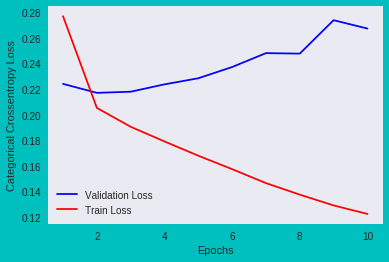

Time taken to run this cell : 1:27:53.818856


In [0]:
start = datetime.now()
embedding_len=32
lstm_1=Sequential()
lstm_1.add(Embedding(len_voc,
                      embedding_len,
                      input_length=max_review_length))

lstm_1.add(Dropout(0.15))

lstm_1.add(LSTM(100))# Adding first LSTM layer


lstm_1.add(Dropout(0.25))# Adding Dropout


lstm_1.add(Dense(1, activation='sigmoid'))# Adding output layer

# Printing the model summary
print(lstm_1.summary())

# Compiling the model
lstm_1.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fitting the data to the model
history_1 = lstm_1.fit(X_train, Y_train, nb_epoch=10,
                        batch_size=512 ,verbose=1,
                       validation_data=(X_test, Y_test))
#evaluating model
score=lstm_1.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_1=score[0]
test_accuracy_lstm_1=score[1]
train_accuracy_lstm_1=max(history_1.history['acc'])
print('test score :',test_score_lstm_1)
print('test Accuracy :',test_accuracy_lstm_1)

# error plot
x=list(range(1,11))
vy=history_1.history['val_loss'] #validation loss
ty=history_1.history['loss'] # train loss
plt_dynamic(x, vy, ty)

runtime_lstm1=datetime.now() - start
print("Time taken to run this cell :", runtime_lstm1)

#### Observation:
* After looking at training and testing error plot, model can be diagonised as overfitting.
* Traing error slopes down while validation error also slopes and hit at inflection point.
* After the inflection point , validation loss slpoes continuously increasing. 

# 2 RNN with 2 LSTM layer

In [0]:
from keras.layers.normalization import BatchNormalization


In [0]:
start = datetime.now()
embedding_len=32
lstm_2=Sequential()
lstm_2.add(Embedding(len_voc,
                      embedding_len,
                      input_length=max_review_length))

lstm_2.add(Dropout(0.15))


lstm_2.add(LSTM(100,return_sequences=True,
                dropout=0.15,
                recurrent_dropout=0.25))# Adding first LSTM layer

lstm_2.add(BatchNormalization())
lstm_2.add(LSTM(100,
                dropout=0.15,
                recurrent_dropout=0.25))# Adding second LSTM layer



#lstm_2.add(BatchNormalization())
lstm_2.add(Dense(1, activation='sigmoid'))# Adding output layer

# Printing the model summary
print(lstm_2.summary())

# Compiling the model
lstm_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fitting the data to the model
history_2 = lstm_2.fit(X_train, Y_train, nb_epoch=10,
                        batch_size=512 ,verbose=1,
                        validation_data=(X_test, Y_test))
runtime_lstm2=datetime.now() - start
print("Time taken to run this cell :", runtime_lstm2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           2348992   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 100)          53200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 100)          400       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,483,093
Trainable params: 2,482,893
Non-trainable params: 200
________________________________________________________________

test score : 0.3063991781577867
test Accuracy : 0.9087469080313448


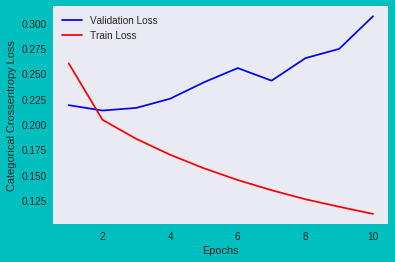

In [0]:
#evaluating model
score=lstm_2.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_2=score[0]
test_accuracy_lstm_2=score[1]
train_accuracy_lstm_2=max(history_2.history['acc'])
print('test score :',test_score_lstm_2)
print('test Accuracy :',test_accuracy_lstm_2)
# error plot
x=list(range(1,11))
vy=history_2.history['val_loss'] #validation loss
ty=history_2.history['loss'] # train loss
plt_dynamic(x, vy, ty)


# 3 RNN with 4 LSTM layer

In [0]:
start = datetime.now()
embedding_len=32
lstm_4=Sequential()
lstm_4.add(Embedding(len_voc,
                      embedding_len,
                      input_length=max_review_length))

lstm_4.add(Dropout(0.25))


lstm_4.add(LSTM(100,return_sequences=True,
                dropout=0.15,
                recurrent_dropout=0.25))# Adding first LSTM layer
lstm_4.add(LSTM(80,return_sequences=True,
                dropout=0.15,
                recurrent_dropout=0.25))# Adding second LSTM layer


lstm_4.add(BatchNormalization())
lstm_4.add(LSTM(50,return_sequences=True,
                dropout=0.15,
                recurrent_dropout=0.25))# Adding Third LSTM layer
lstm_4.add(BatchNormalization())
lstm_4.add(LSTM(40,
                dropout=0.15))# Adding Fourth LSTM layer
lstm_4.add(BatchNormalization())


lstm_4.add(Dense(1, activation='sigmoid'))# Adding output layer

# Printing the model summary
print(lstm_4.summary())

# Compiling the model
lstm_4.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fitting the data to the model
history_4 = lstm_4.fit(X_train, Y_train, nb_epoch=10,
                        batch_size=512 ,verbose=1,
                        validation_data=(X_test, Y_test))
runtime_lstm4=datetime.now() - start
print("Time taken to run this cell :", runtime_lstm4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           2348992   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 80)           57920     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 80)           320       
_________________________________________________________________
lstm_3 (LSTM)                (None, 120, 50)           26200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 50)           200       
__________

test score : 0.2522423982056529
test Accuracy : 0.9075177391425236


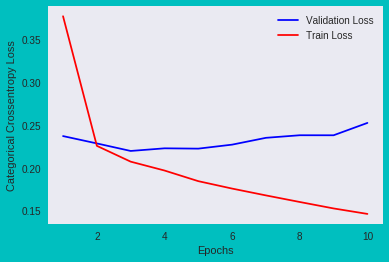

In [0]:
#evaluating model
score=lstm_4.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_4=score[0]
test_accuracy_lstm_4=score[1]
train_accuracy_lstm_4=max(history_4.history['acc'])
print('test score :',test_score_lstm_4)
print('test Accuracy :',test_accuracy_lstm_4)
# error plot
x=list(range(1,11))
vy=history_4.history['val_loss'] #validation loss
ty=history_4.history['loss'] # train loss
plt_dynamic(x, vy, ty)


# 4 RNN with 5 LSTM layer

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           2348992   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 120)          73440     
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 100)          88400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 100)          400       
_________________________________________________________________
lstm_3 (LSTM)        

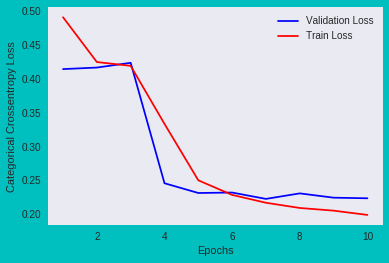

Time taken to run this cell : 9:02:45.687949


In [0]:
start = datetime.now()
embedding_len=32
lstm_5=Sequential()
lstm_5.add(Embedding(len_voc,
                      embedding_len,
                      input_length=max_review_length))

lstm_5.add(Dropout(0.45))

lstm_5.add(LSTM(120,return_sequences=True,
                dropout=0.35,
                recurrent_dropout=0.25))# Adding first LSTM layer
lstm_5.add(LSTM(100,return_sequences=True,
                dropout=0.35,
                recurrent_dropout=0.35))# Adding second LSTM layer
lstm_5.add(BatchNormalization())
lstm_5.add(LSTM(100,return_sequences=True,
                dropout=0.35,
                recurrent_dropout=0.35))# Adding Third LSTM layer
lstm_5.add(BatchNormalization())
lstm_5.add(LSTM(80,return_sequences=True,
                dropout=0.35,
                recurrent_dropout=0.35))# Adding Fourth LSTM layer
lstm_5.add(BatchNormalization())
lstm_5.add(LSTM(60,dropout=0.35,
                recurrent_dropout=0.35))# Adding Fifth LSTM layer
lstm_5.add(BatchNormalization())
lstm_5.add(Dense(1, activation='sigmoid'))# Adding output layer

# Printing the model summary
print(lstm_5.summary())

# Compiling the model
lstm_5.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fitting the data to the model
history_5 = lstm_5.fit(X_train, Y_train, nb_epoch=10,
                        batch_size=512 ,verbose=1,
                        validation_data=(X_test, Y_test))
#evaluating model
score=lstm_5.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_5=score[0]
test_accuracy_lstm_5=score[1]
train_accuracy_lstm_5=max(history_5.history['acc'])
print("Train Accuracy",train_accuracy_lstm_5)
print('test score :',test_score_lstm_5)
print('test Accuracy :',test_accuracy_lstm_5)
# error plot
x=list(range(1,11))
vy=history_5.history['val_loss'] #validation loss
ty=history_5.history['loss'] # train loss
plt_dynamic(x, vy, ty)
runtime_lstm5=datetime.now() - start
print("Time taken to run this cell :", runtime_lstm5)

In [0]:

print('Train loss',ty)

Train loss [0.49096747402106294, 0.4247921708370311, 0.4191692316861523, 0.33343958246519, 0.2501070746763699, 0.2285251474087435, 0.21694653656777207, 0.20923510087015956, 0.20528901007566835, 0.19897864129135445]


In [0]:
print('test score',test_score_lstm_5)

test score 0.2235467241037283


# Observation

In [0]:
from prettytable import PrettyTable
models=['RNN With 1 LSTM Layer',
        'RNN With 2 LSTM Layer',
        'RNN With 4 LSTM Layer',
       'RNN With 5 LSTM Layer']
training_accuracy=[train_accuracy_lstm_1,train_accuracy_lstm_2,
                   train_accuracy_lstm_4,train_accuracy_lstm_5]
test_accuracy=[test_accuracy_lstm_1,test_accuracy_lstm_2,
               test_accuracy_lstm_4,test_accuracy_lstm_5]
INDEX = [1,2,3,4]
# Initializing prettytable
Model_Performance = PrettyTable()
# Adding columns
Model_Performance.add_column("INDEX.",INDEX)
Model_Performance.add_column("MODEL_NAME",models)
Model_Performance.add_column("TRAINING ACCURACY",training_accuracy)
Model_Performance.add_column("TESTING ACCURACY",test_accuracy)
#Model_Performance.add_column("TEST SCORE",test_score)

# Printing the Model_Performance
print(Model_Performance)

+--------+-----------------------+-------------------+------------------+
| INDEX. |       MODEL_NAME      | TRAINING ACCURACY | TESTING ACCURACY |
+--------+-----------------------+-------------------+------------------+
|   1    | RNN With 1 LSTM Layer |       0.9423      |      0.9035      |
|   2    | RNN With 2 LSTM Layer |       0.9392      |      0.9087      |
|   3    | RNN With 4 LSTM Layer |      0.936954     |      0.9075      |
|   4    | RNN With 5 LSTM Layer |       0.9202      |      0.9108      |
+--------+-----------------------+-------------------+------------------+
